# Introduction 
 
Chess is a game of fine margins. There are many different strategies and techniques players can use to their advantage to win. 
Through our analysis of the chess data we hope that we can accurately predict what combinations of opening moves and other factors will contribute to them winning. 
There are three different hypothosis that we will attempt to observe as we analyze the data. The first is that aggressiveness benefits white more becuase white goes first 
and sets the pace making black have to follow and respond. The next hypothosis is that since white moves first therefore black is less likely to win. Finally our last hypothesis 
that we hope to answer is that because white has an implicit benefit, the more skilled player will more likely be assined as black to start to the game in order to balance the 
skill level

# About the Data 
  
We obtained the data from a dataset provided by a user on kaggle. Said user aquired the data from a web application called Lichess.org using the API provided by the site. The creater of the data set had to pull data using usernames which he gathered from obtaining a list of users in various teams. He stated that the size of some of these teams are quite large and that is the reason he was able to get a relatively large dataset. This is important to keep in mind as it is potential source of bias in the data. In spite of this minor fault, we feel like we can still learn some interesting information from the data.

Link to the data: https://www.kaggle.com/datasets/datasnaek/chess 

The size of this dataset has 20058 rows with with 16 variables. 

The 16 variables:
* game ID (str): unique identifier for each game
* rated (boolean): whether or not the game counted for a rating 
* created_at (date): when the game started
* last_move_at (date): when the game ended
* turns (int): how many turns in the game
* victory status (categorical): how did the game end? Ie out of time or resign
* winner (categorical): who won
* increment_code (str): time control
* white_id (str): id of white player
* white_rating (int): rating of white player
* black_id (str): id of black player
* black_rating (int): rating of black player
* moves (str): every move made in order
* opening_eco (categorical): code associated with opening name
* opening name (categorical): opening moves strategy name
* opening_ply (int): number of moves in opening phase

# Methods

We want to keep the 'serious' games and get rid of the games consisting of poorer performing players. The rating of players starts at 1500, thus, games with players rated under 1500 were filtered out. Additionally, only the ranked games were kept.   
In an effort to only keep definite winners, all games that ended without a checkmate were also dropped, ie out of time and resignation. We chose to do this due to the games taking place over the internet where connectivity could determine the other outcomes. We decided the lesser of two evils would be to drop them all together rather then our results being affected by an external force. 

In addition to these modifications, some variables were also added: rating difference, number of checks per game, and number of pawn changes per game.

>our imports

In [83]:
# for dataframes
import pandas as pd
pd.set_option('display.max_columns', None)

# for nice plots
import seaborn as sns
import matplotlib.pyplot as plt

# to disable warnings
import warnings
warnings.filterwarnings('ignore')

# for some statistical analysis
from statsmodels.stats.proportion import proportions_ztest, tost_proportions_2indep

>loading and filtering our df

In [84]:
df = pd.read_csv('archive.zip')
print(df.shape)
df = df.drop(['created_at', 'last_move_at', 'increment_code', 'white_id', 'black_id'], axis=1)
df = df.loc[(df['victory_status'] == 'mate') & 
            (df['rated'] == True) & 
            (df['white_rating'] > 1500) &
            (df['black_rating'] > 1500)]
df['rating_diff'] = df['white_rating'] - df['black_rating']

(20058, 16)


In [85]:
df.head()

,id,rated,turns,victory_status,winner,white_rating,black_rating,moves,opening_eco,opening_name,opening_ply,rating_diff
64,XuyVUkDi,True,40,mate,black,1618,1568,e4 e6 Bc4 d5 exd5 exd5 Bb3 Qe7+ Ne2 Nf6 d4 Nc6...,C00,French Defense #2,2,50
71,DHuXFP6C,True,87,mate,white,1617,1590,d4 Nf6 e3 g6 f4 Bg7 Nf3 d5 c4 O-O Nc3 c6 Bd3 e...,A45,Indian Game,2,27
79,7kK30TmL,True,64,mate,black,1768,1560,e4 e6 f4 d5 e5 c5 Nf3 Nc6 c3 Nh6 d4 cxd4 cxd4 ...,C00,French Defense: La Bourdonnais Variation,3,208
81,4dH72B3d,True,57,mate,white,1536,1667,d4 Nf6 Bf4 d5 Nf3 Nc6 e3 Bg4 h3 Bh5 c4 e6 Qa4 ...,D02,Queen's Pawn Game: London System,5,-131
95,TVfozmF5,True,85,mate,white,1513,1784,d4 e6 Bf4 d5 Nf3 Qe7 e3 c5 c3 cxd4 Bb5+ Bd7 Bx...,A40,Horwitz Defense,2,-271


In [86]:
df.describe()

,turns,white_rating,black_rating,opening_ply,rating_diff
count,1986.000000,1986.000000,1986.000000,1986.000000,1986.000000
mean,73.377644,1761.833837,1767.731118,5.199396,-5.897281
std,35.597164,185.592502,186.174197,2.920357,177.174475
min,4.000000,1501.000000,1501.000000,1.000000,-726.000000
25%,48.000000,1612.000000,1614.000000,3.000000,-89.000000
50%,65.500000,1730.000000,1737.000000,5.000000,-1.500000
75%,94.000000,1870.000000,1879.750000,7.000000,77.000000
max,222.000000,2447.000000,2462.000000,19.000000,715.000000


In [87]:
df.loc[df['rating_diff'] > 700]

,id,rated,turns,victory_status,winner,white_rating,black_rating,moves,opening_eco,opening_name,opening_ply,rating_diff
4899,hgwn2QJz,True,35,mate,white,2291,1576,e4 e5 Nf3 Nc6 Bb5 a6 Ba4 Nf6 d3 Bc5 O-O O-O Bx...,C77,Ruy Lopez: Morphy Defense | Anderssen Variation,9,715


In [88]:
df.loc[df['rating_diff'] < -700]

,id,rated,turns,victory_status,winner,white_rating,black_rating,moves,opening_eco,opening_name,opening_ply,rating_diff
6981,rxfAX58s,True,122,mate,black,1540,2266,d4 d5 c3 Nc6 b3 a6 a3 e6 e3 Nf6 f3 e5 Bd3 e4 f...,D00,Queen's Pawn Game,2,-726


Text(0.5, 0, 'Difference')

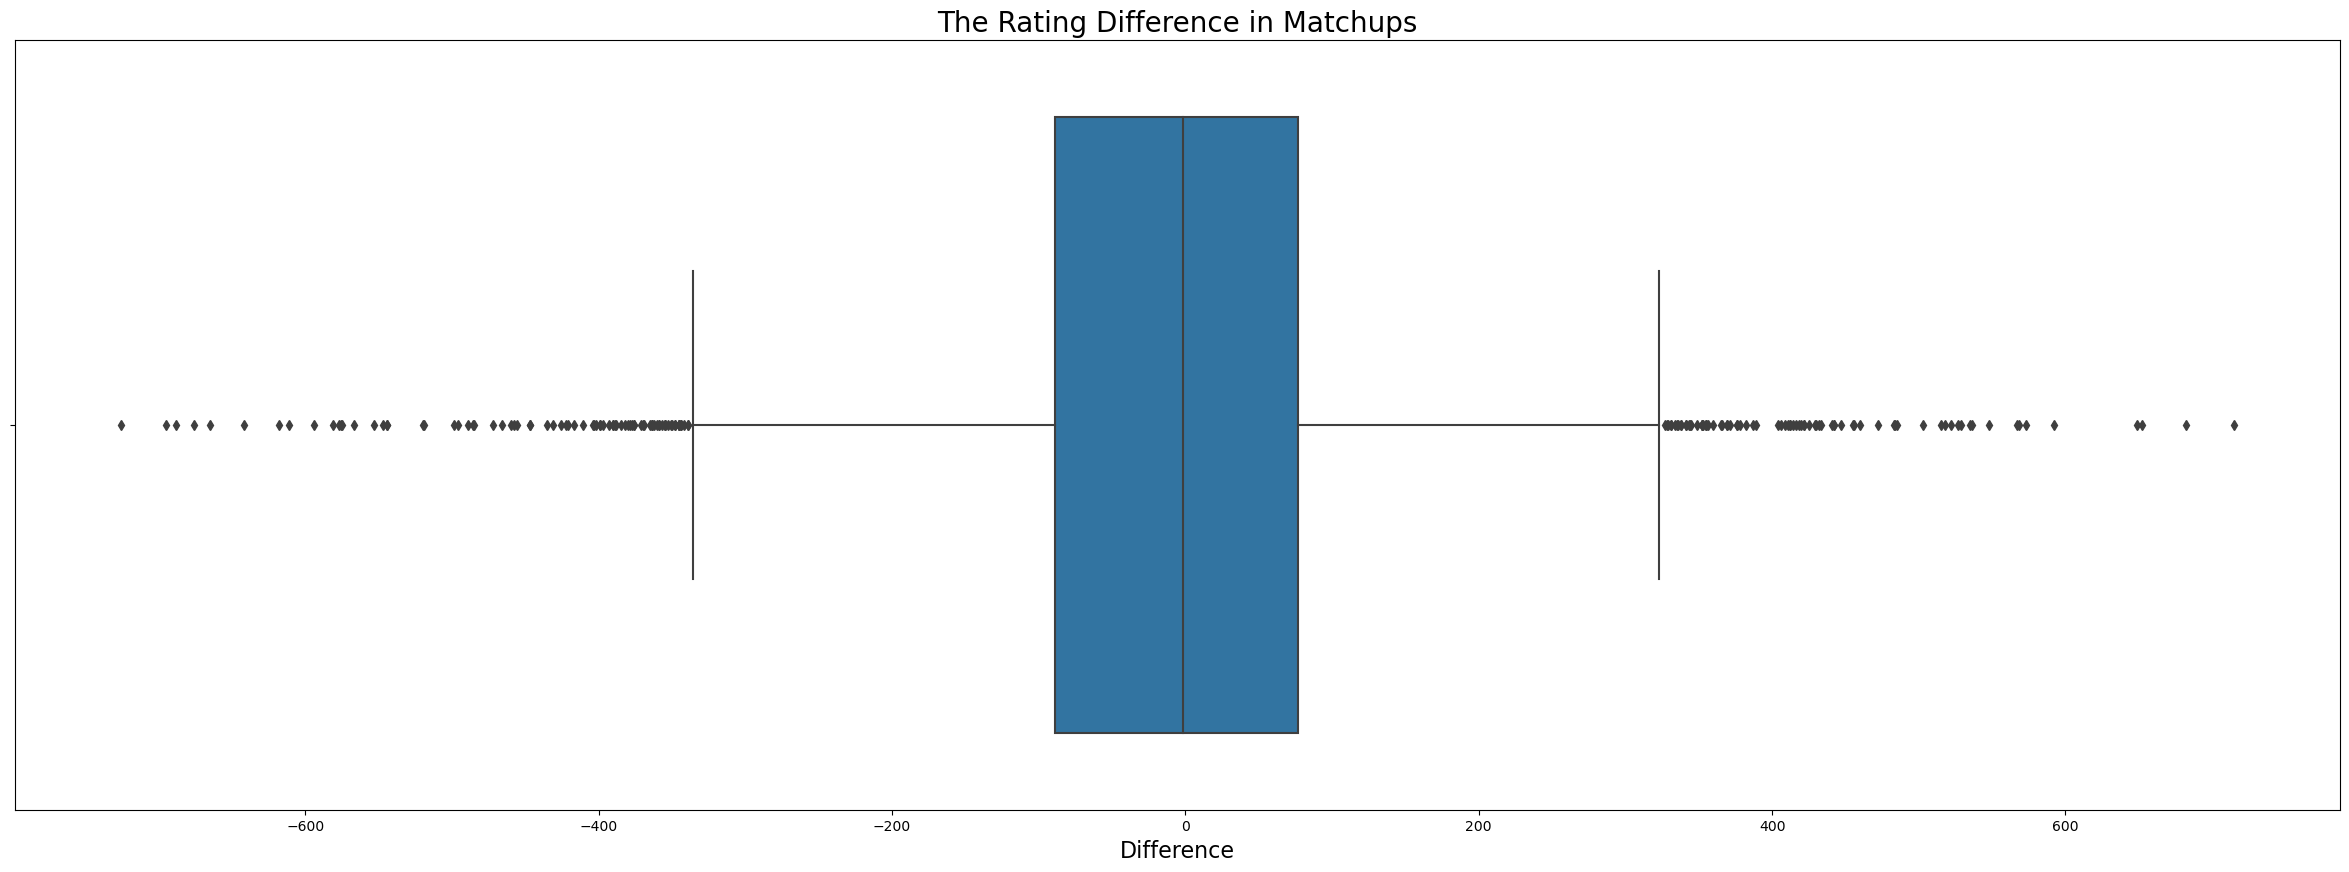

In [89]:
plt.figure(figsize=(30,10))
ar = sns.boxplot(data = df, x = 'rating_diff')
ar.set_title('The Rating Difference in Matchups', fontsize=20)
ar.set_xlabel('Difference', fontsize=16)

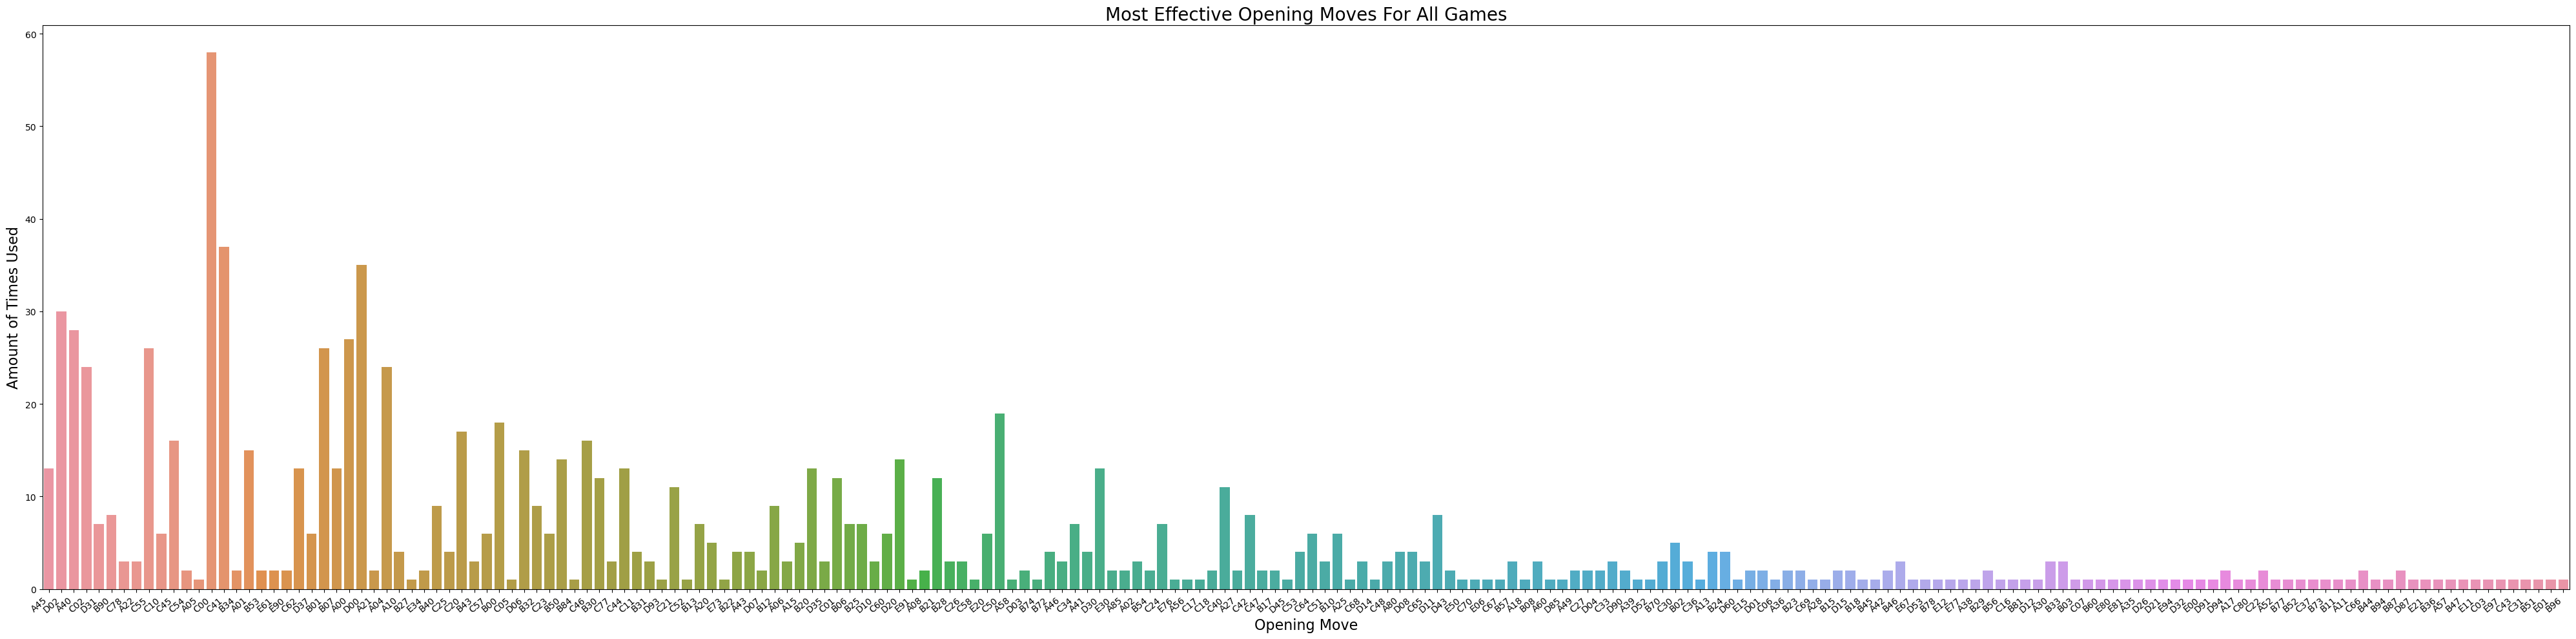

In [90]:
plt.figure(figsize=(40,10))
ao = sns.countplot(data = df.loc[(df['winner'] == 'white')], x='opening_eco')
ao.set_xticklabels(ao.get_xticklabels(), rotation=40, ha="right")
ao.set_title('Most Effective Opening Moves For All Games', fontsize=20)
ao.set_xlabel('Opening Move', fontsize=16)
ao.set_ylabel('Amount of Times Used', fontsize=16)
plt.tight_layout()
plt.show()

How many game moves were duplicates of another?

In [91]:
df.loc[df['moves'].duplicated()]

,id,rated,turns,victory_status,winner,white_rating,black_rating,moves,opening_eco,opening_name,opening_ply,rating_diff
862,eP09Yv7W,True,4,mate,black,1527,1882,f4 e6 g4 Qh4#,A02,Bird Opening,1,-355
864,V7a3QIoB,True,4,mate,black,1533,1897,f4 e6 g4 Qh4#,A02,Bird Opening,1,-364
867,pSa9EQDs,True,4,mate,black,1552,1887,f4 e6 g4 Qh4#,A02,Bird Opening,1,-335
10327,Iuo32IUI,True,41,mate,white,2247,2094,e4 c5 b4 cxb4 a3 bxa3 Nxa3 Nc6 d4 d5 exd5 Qxd5...,B20,Sicilian Defense: Wing Gambit | Carlsbad Vari...,6,153
11214,hrnqkGeJ,True,54,mate,black,2004,2073,e4 Nf6 Nc3 e5 Nf3 Nc6 d4 exd4 Nxd4 Bb4 Nxc6 bx...,C47,Four Knights Game: Scotch Variation Accepted,8,-69
...,...,...,...,...,...,...,...,...,...,...,...,...
19336,lmk7lokQ,True,98,mate,black,2104,2098,e4 c6 Nc3 d5 d4 dxe4 Nxe4 Bf5 Ng3 Bg6 Nf3 Nd7 ...,B19,Caro-Kann Defense: Classical | Spassky Variation,15,6
19337,34BzwAwa,True,43,mate,white,2029,2117,e4 e5 Nf3 Nc6 Nc3 Nf6 Bb5 d6 d4 exd4 Nxd4 Bd7 ...,C48,Four Knights Game: Spanish Variation,7,-88
19339,63PiJLzL,True,70,mate,black,1706,1983,d4 Nf6 Bf4 d5 Nf3 c5 Nbd2 cxd4 Nxd4 Nbd7 Bg3 e...,D02,Queen's Pawn Game: London System,5,-277
19342,2KGzYnb8,True,52,mate,black,1728,1662,e4 c6 d4 d5 e5 Bf5 Bd3 Bxd3 Qxd3 Qb6 c3 Nd7 Ne...,B12,Caro-Kann Defense: Advance Variation,5,66


>Games that end in four or fewer moves are too quick

In [92]:
df = df.loc[df['turns'] > 4]

In [93]:
counts = df['opening_eco'].value_counts()

In [94]:
counts = counts.loc[counts < 5]

In [95]:
counts = list(counts.index)

In [96]:
df = df[~df.opening_eco.isin(counts)]

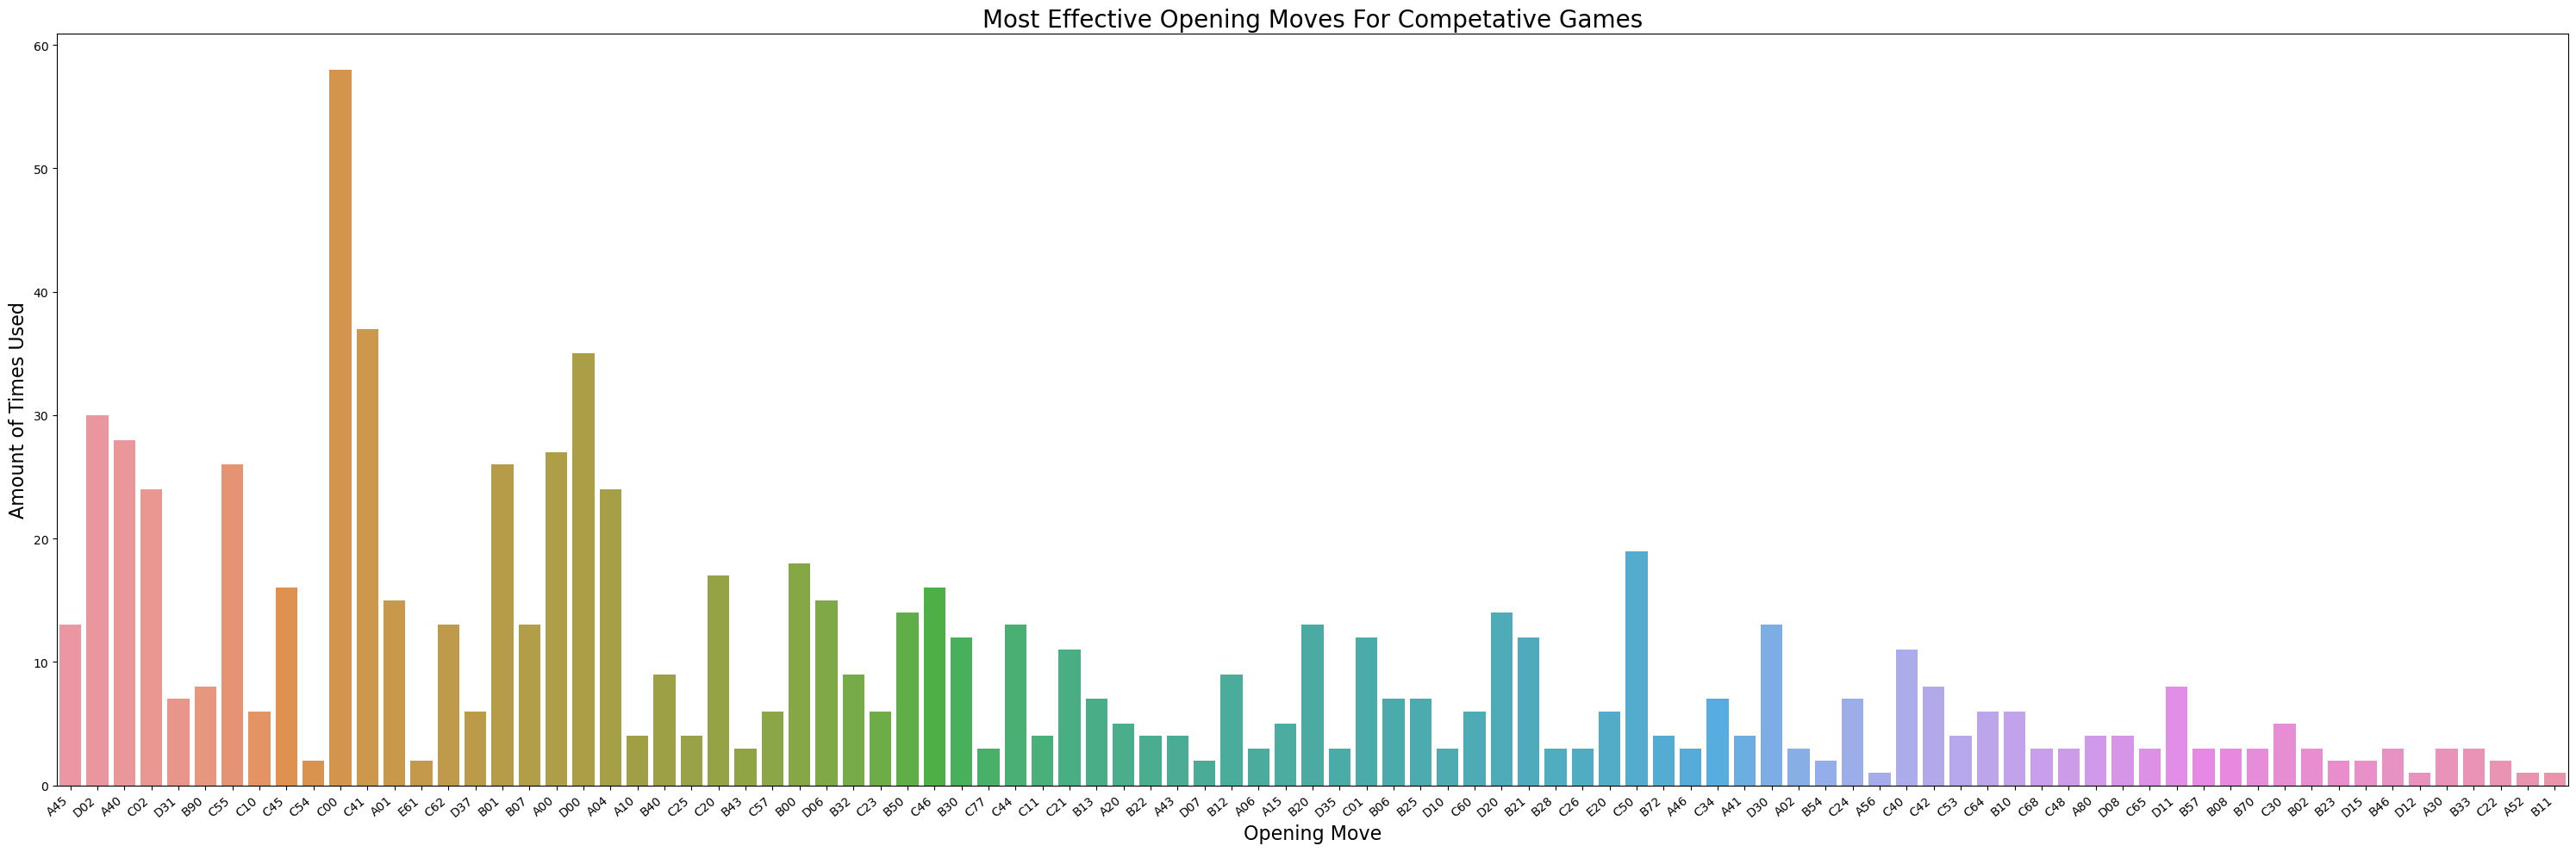

In [97]:
plt.figure(figsize=(30,10))
an = sns.countplot(data = df.loc[(df['winner'] == 'white')], x='opening_eco')
an.set_xticklabels(an.get_xticklabels(), rotation=40, ha="right")
an.set_title('Most Effective Opening Moves For Competative Games', fontsize=20)
an.set_xlabel('Opening Move', fontsize=16)
an.set_ylabel('Amount of Times Used', fontsize=16)
plt.tight_layout()
plt.show()

In [98]:
df.shape

(1709, 12)

In [99]:
df.describe()

,turns,white_rating,black_rating,opening_ply,rating_diff
count,1709.000000,1709.000000,1709.000000,1709.000000,1709.000000
mean,73.164424,1753.471621,1759.155647,4.777063,-5.684026
std,35.421358,180.567762,182.456043,2.515765,172.599554
min,5.000000,1501.000000,1501.000000,1.000000,-726.000000
25%,48.000000,1609.000000,1610.000000,3.000000,-86.000000
50%,65.000000,1722.000000,1727.000000,4.000000,-1.000000
75%,94.000000,1860.000000,1871.000000,6.000000,75.000000
max,222.000000,2447.000000,2462.000000,19.000000,715.000000


In [100]:
for move in df.loc[df['turns'] == 160]['moves']:
    print(move)

e4 e6 Bc4 d5 exd5 exd5 Bb3 Nf6 d3 h6 Nc3 Bc5 Qf3 Bg4 Qg3 O-O h4 Re8+ Nge2 Bb4 Bd2 Bxe2 Nxe2 Bxd2+ Kxd2 Nc6 Rae1 a5 a3 a4 Ba2 Re6 h5 Ne5 Nf4 Re8 Nh3 Qd6 f4 Ned7 Qf3 Rxe1 Rxe1 Re8 Bxd5 Rxe1 Bxf7+ Kxf7 Kxe1 Qc6 Qf2 Nxh5 g4 Qe6+ Kd1 Qxg4+ Kc1 Qxh3 Kb1 Qf5 Qe3 Nxf4 Qa7 Qd5 Qxa4 Ne6 Qb4 Qc6 Qg4 g5 Qh5+ Kg7 Qe8 Ne5 Qh5 Nf4 Qh2 Qg6 Qd2 Nf3 Qb4 b6 Qe7+ Qf7 Qe3 Nh4 Qd4+ Qf6 Qd7+ Kg6 Qe8+ Qf7 Qe4+ Nf5 Qc6+ Nd6 d4 h5 d5 Nxd5 c4 Nf4 Qf3 Qxc4 Qf2 Qe2 Qg3 Nc4 Qb3 Qxb2+ Qxb2 Nxb2 Kxb2 h4 Kb3 h3 Kb4 h2 Kb5 h1=Q Ka6 Ne6 Kb5 Qa1 Kb4 g4 Kc4 g3 Kd3 g2 Ke4 g1=Q Kd5 Qg2+ Kxe6 Qd4 Ke7 Qc6 Kf8 b5 a4 Qxa4 Ke7 Qac4 Kd8 b4 Kc8 b3 Kb8 Qe8+ Kb7 Qcb5+ Kxc7 b2 Kd6 b1=Q Kc7 Qc1+ Kd6 Qee5#


>How many checks per game? (+)   
>How many new queens per game? (=)

In [101]:
df['num_checks'] = 0
df['pawn_change'] = 0


index = 0
for each in df['moves']:
    gameCheck = 0
    gameChange = 0
    for x in each:
        if x == '+' or x == '#':
            gameCheck += 1
        if x == '=':
            gameChange += 1
    df['num_checks'].iloc[index] = gameCheck
    df['pawn_change'].iloc[index] = gameChange
    index+=1


Text(0.5, 0, 'Number of Turns')

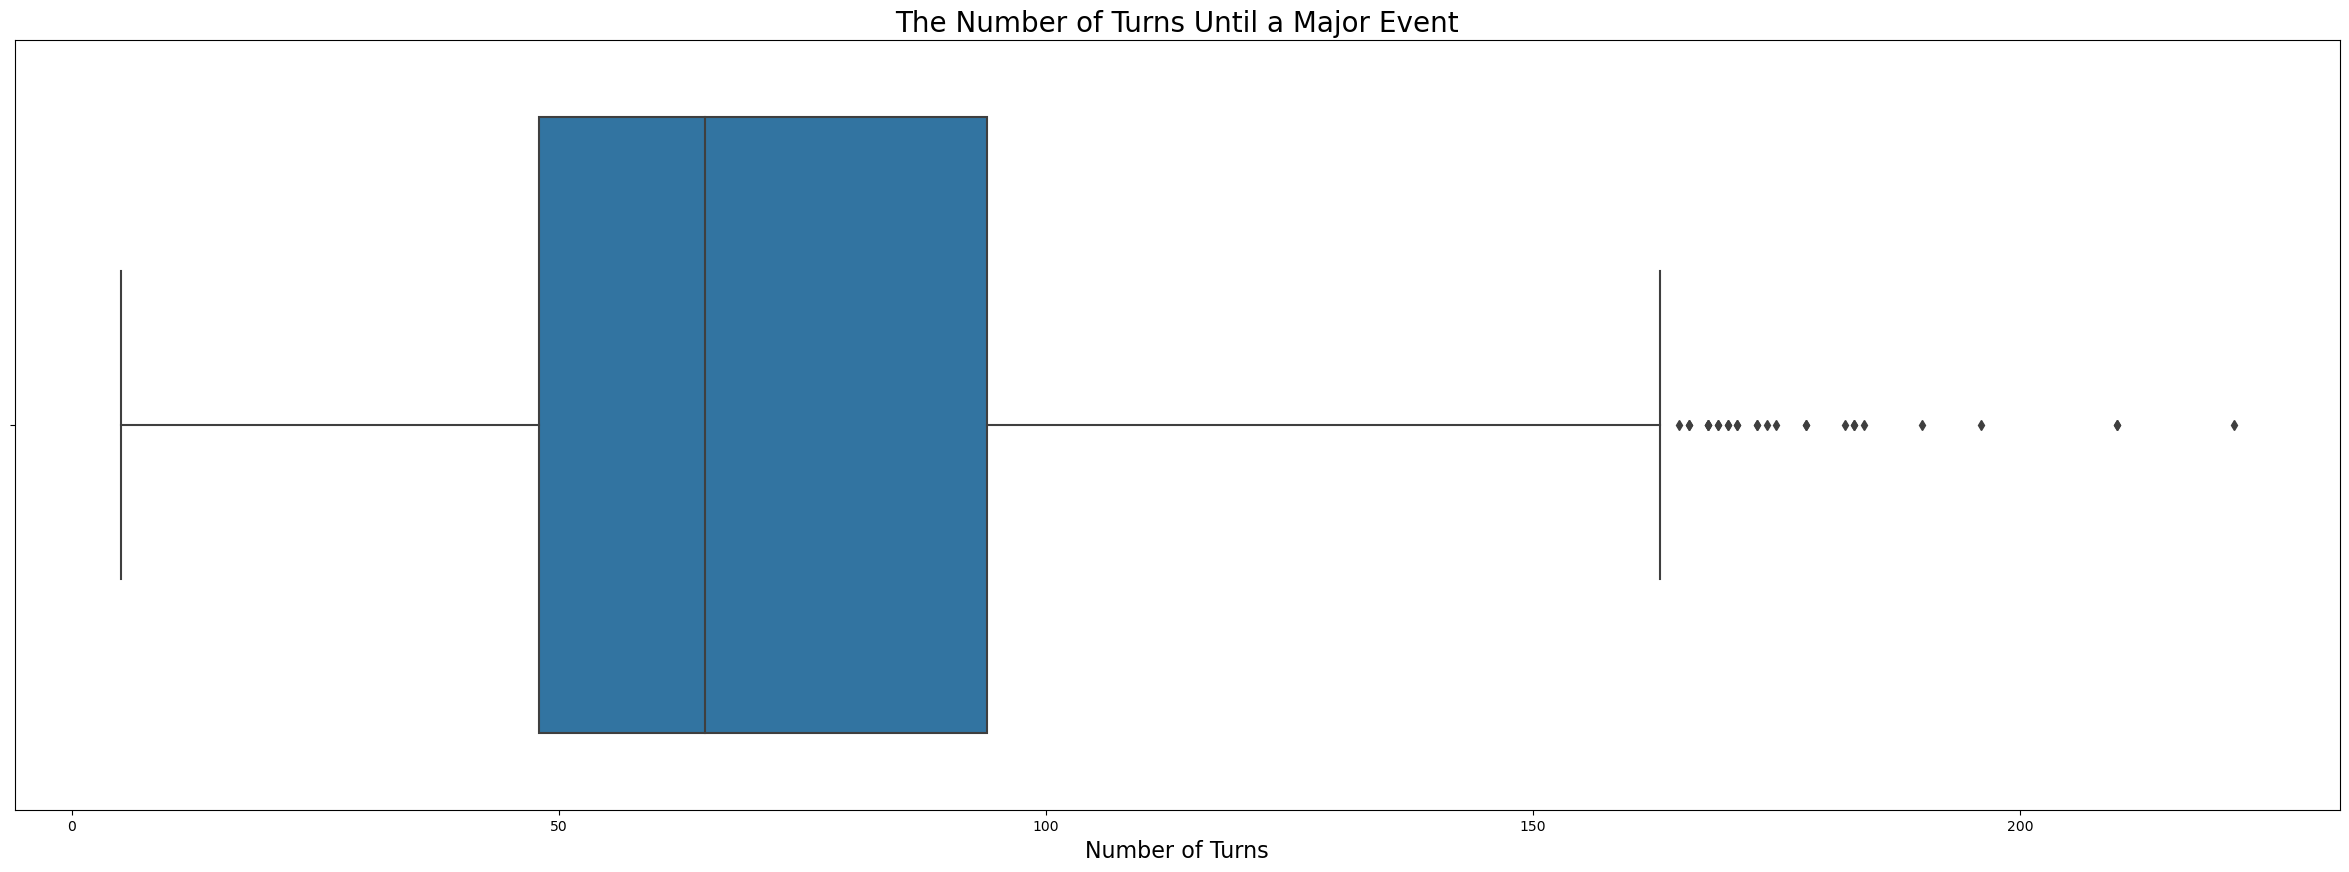

In [102]:
plt.figure(figsize=(30,10))
at = sns.boxplot(data = df, x = 'turns')
at.set_title('The Number of Turns Until a Major Event', fontsize=20)
at.set_xlabel('Number of Turns', fontsize=16)

In [103]:
df.head()

,id,rated,turns,victory_status,winner,white_rating,black_rating,moves,opening_eco,opening_name,opening_ply,rating_diff,num_checks,pawn_change
64,XuyVUkDi,True,40,mate,black,1618,1568,e4 e6 Bc4 d5 exd5 exd5 Bb3 Qe7+ Ne2 Nf6 d4 Nc6...,C00,French Defense #2,2,50,4,0
71,DHuXFP6C,True,87,mate,white,1617,1590,d4 Nf6 e3 g6 f4 Bg7 Nf3 d5 c4 O-O Nc3 c6 Bd3 e...,A45,Indian Game,2,27,5,0
79,7kK30TmL,True,64,mate,black,1768,1560,e4 e6 f4 d5 e5 c5 Nf3 Nc6 c3 Nh6 d4 cxd4 cxd4 ...,C00,French Defense: La Bourdonnais Variation,3,208,6,0
81,4dH72B3d,True,57,mate,white,1536,1667,d4 Nf6 Bf4 d5 Nf3 Nc6 e3 Bg4 h3 Bh5 c4 e6 Qa4 ...,D02,Queen's Pawn Game: London System,5,-131,2,0
95,TVfozmF5,True,85,mate,white,1513,1784,d4 e6 Bf4 d5 Nf3 Qe7 e3 c5 c3 cxd4 Bb5+ Bd7 Bx...,A40,Horwitz Defense,2,-271,7,0


# Evaluation

Due to the fact that white makes the first move we believe it will have a significant impact on which team wins.  
2 population proportion   
significance level = 0.05   
n=1709   
Ho: p1 = p2   
Ha: p1 != p2   
if p <= 0.05 then reject   
if p > 0.05 fail to reject   

In [104]:
list(df['winner'].value_counts())

[866, 843]

In [105]:
# number of trials. aka the total number of games, our n
nobs = [df['winner'].value_counts().sum()]*2

# number of wins for each player, so 866 and 843
count = count=list(df['winner'].value_counts())  

In [106]:
zstat, pval = proportions_ztest(count, nobs, alternative = 'two-sided' )

In [107]:
print(round(pval,2))

0.43


### With a p-value of 0.43 > 0.05 we now know that they are statistically the same! They win at the same rates!

In [108]:
# .tost_proportions_2indep(count1, nobs1, count2, nobs2, low, upp, method=None, compare='diff', correction=True)
tost_proportions_2indep(count1 = list(df['winner'].value_counts())[0],
                        count2 = list(df['winner'].value_counts())[1],
                        nobs1 = df['winner'].value_counts().sum(),
                        nobs2 = df['winner'].value_counts().sum(),
                        low=0,
                        upp=0,
                        compare='diff')

<class 'statsmodels.stats.base.HolderTuple'>
statistic = 0.7864245652046729
pvalue = 0.21580939829238888
compare = 'diff'
method = None
results_larger = <class 'statsmodels.stats.base.HolderTuple'>
    statistic = 0.7864245652046729
    pvalue = 0.21580939829238888
    compare = 'diff'
    method = 'agresti-caffo'
    diff = 0.01345816266822708
    ratio = 1.0272835112692764
    odds_ratio = 1.0553114125257337
    variance = 0.0002921739628988973
    alternative = 'larger'
    value = 0
    tuple = (0.7864245652046729, 0.21580939829238888)
results_smaller = <class 'statsmodels.stats.base.HolderTuple'>
    statistic = 0.7864245652046729
    pvalue = 0.7841906017076111
    compare = 'diff'
    method = 'agresti-caffo'
    diff = 0.01345816266822708
    ratio = 1.0272835112692764
    odds_ratio = 1.0553114125257337
    variance = 0.0002921739628988973
    alternative = 'smaller'
    value = 0
    tuple = (0.7864245652046729, 0.7841906017076111)
title = 'Equivalence test for 2 independent 

>And again just in case...      
p-val of 0.21   
Definitely the same, statistically

# Model

In [135]:
df = df.sort_values(by='num_checks', ascending=False)

In [136]:
df['num_checks']

16943    46
18985    39
11890    38
582      36
17250    35
         ..
4899      1
4992      1
17687     1
5013      1
12297     1
Name: num_checks, Length: 1709, dtype: int64

In [137]:
df = df.sort_values(by='pawn_change', ascending=False)

In [138]:
df['pawn_change']

19776    4
17154    3
3340     3
8279     3
18626    3
        ..
3349     0
4891     0
15237    0
7722     0
12297    0
Name: pawn_change, Length: 1709, dtype: int64

In [139]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [140]:
X = df[['pawn_change']]
y = df['num_checks']
x_train, x_test, y_train, y_test = train_test_split(X,y)

In [141]:
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

In [142]:
print('Coefficients: \n', lr.coef_)
print('Intercept: \n', lr.intercept_)

Coefficients: 
 [4.21142288]
Intercept: 
 5.718271034693871


In [143]:
lr.predict([[0]])

array([5.71827103])

In [144]:
lr.predict([[1]])

array([9.92969392])

In [145]:
lr.predict([[2]])

array([14.1411168])

In [146]:
lr.predict([[3]])

array([18.35253968])

In [147]:
lr.predict([[4]])

array([22.56396256])

# Storytelling and Conclusion
What insights did you gain through your project? Were you able to answer your initial problems? Obtain your initial goal? What stories can you tell? Do you have future steps in mind or things that could have been improved? ***For full credit here, you will need to show your critical thinking throughout.***

What have you learned throughout this project and the entire class?

With this project we were able to 

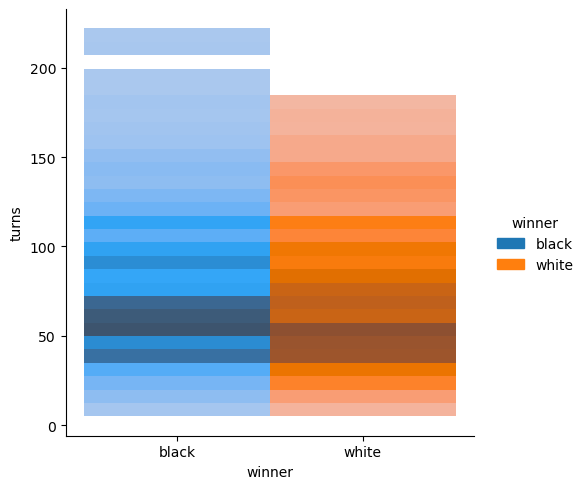

In [109]:
sns.displot(data=df[['turns', 'winner']], x='winner', y='turns', hue='winner')

# Impact Section

When formulating strategies it shows that white can be successful early on by being aggressive it can also serve as a double edge sword with them being careless and black getting the upper hand. As said before that around 60 moves is when Black can gain the advantage. However since games are an average of 73 moves it can become too late for black to win if passive for too long. 
Since our analysis showed that lichess does not balance games based on skill rating. Whether a player is a assigned white or black is at random and rating has no impact. As it is seen at a the high level of chess there is an equal win rate for both sides. 
When identifying winning openings if assigned white or black the start will differ. White has a lot of flexibility in the attack due to going first so black is almost always has to then react to what white does. Knowing this at the start of of the game when players are assigned they can then begin to form their openings and counter measures. 


# Github Repository & Kaggle Dataset

GitHub repo: https://github.com/matthewasloan95/chess

Kaggle dataset: https://www.kaggle.com/datasets/datasnaek/chess